In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
import seaborn as sns

## Importing Data

In [2]:
data = pd.read_csv(r'C:\Users\Matúš\.jupyter\csv\IMDB Dataset.csv')

In [3]:
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [4]:
len(data)

50000

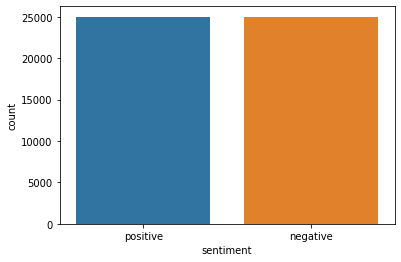

In [5]:
sns.countplot(data=data, x='sentiment');

## Preparing Data

In [6]:
from sklearn.model_selection import train_test_split

x = data['review']
y = data['sentiment']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=42)

#### Preprocess 'y'

In [7]:
y_train = y_train.apply(lambda x: 1 if x=='positive' else 0)

In [8]:
y_test = y_test.apply(lambda x: 1 if x=='positive' else 0)

#### Preprocess 'x'

In [9]:
from collections import Counter
import re

vocabulary = Counter()

def preprocess_text(texts, vocab=False,  max_length=100):
   
    splitted_text = []
        
    for review in texts:
        process0 = review.lower()
        process1 = re.sub(r'<br />', '', process0)
        process2 = re.findall(r'[a-zA-Z]+', process1)
        splitted_text.append(process2[:max_length])

    prepared_text = tf.ragged.constant(splitted_text).to_tensor(default_value=b'<pads>')

    if vocab:
        for review in prepared_text:
            vocabulary.update(list(review.numpy()))
          
        return vocabulary

    else:        
        return prepared_text

In [10]:
vocabulary = preprocess_text(x_train, vocab=True)

In [11]:
len(vocabulary)

66112

In [12]:
vocabulary.most_common(20)

[(b'the', 244392),
 (b'<pads>', 169479),
 (b'a', 124109),
 (b'and', 117428),
 (b'of', 108211),
 (b'to', 94180),
 (b'i', 85356),
 (b'is', 80882),
 (b'it', 76873),
 (b'this', 67397),
 (b'in', 67036),
 (b'that', 51596),
 (b's', 44271),
 (b'was', 43348),
 (b'movie', 41616),
 (b'film', 31607),
 (b'as', 31465),
 (b'with', 31163),
 (b'but', 30394),
 (b'for', 30291)]

In [13]:
vocabulary_df = pd.DataFrame(vocabulary.items()).sort_values(by=1, ascending=False)

In [14]:
vocabulary_df

,0,1
18,b'the',244392
414,b'<pads>',169479
62,b'a',124109
6,b'and',117428
21,b'of',108211
...,...,...
48542,b'jokei',1
48541,b'titltes',1
38022,b'amputees',1
48539,b'marlboro',1


In [15]:
vocab_size = len(vocabulary_df)

In [16]:
indeces = tf.range(0, limit=len(vocabulary_df), dtype=tf.int64)
table_init = tf.lookup.KeyValueTensorInitializer(vocabulary_df.iloc[:, 0], indeces)

In [17]:
num_oov_buckets = 1000
table = tf.lookup.StaticVocabularyTable(table_init, num_oov_buckets=num_oov_buckets)

In [18]:
table.lookup(tf.constant('<pads>'))

<tf.Tensor: shape=(), dtype=int64, numpy=1>

In [19]:
prepared_train_text = preprocess_text(x_train, max_length=50)
prepared_test_text = preprocess_text(x_test, max_length=50)

In [20]:
prepared_train_text

<tf.Tensor: shape=(45000, 50), dtype=string, numpy=
array([[b'i', b'recently', b'started', ..., b'if', b'you', b'are'],
       [b'return', b'of', b'the', ..., b'lines', b'of', b'the'],
       [b'i', b'remember', b'i', ..., b'man', b'this', b'movie'],
       ...,
       [b'avoid', b'this', b'one', ..., b't', b'they', b'leave'],
       [b'this', b'production', b'was', ..., b'you', b'must', b'look'],
       [b'this', b'is', b'a', ..., b'and', b'tense', b'throughout']],
      dtype=object)>

In [21]:
def prepare_data_for_model(x, y):
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.batch(32).prefetch(1)
    return dataset

In [22]:
train_dataset = prepare_data_for_model(table.lookup(prepared_train_text), y_train)
test_dataset = prepare_data_for_model(table.lookup(prepared_test_text), y_test)

## Creating a Model

In [23]:
tf.config.run_functions_eagerly(False)

In [24]:
K = keras.backend

inputs = keras.layers.Input([None])
mask = keras.layers.Lambda(lambda inputs: K.not_equal(inputs, 1))(inputs)  # Mask <pads> tokens
z = keras.layers.Embedding(input_dim=vocab_size + num_oov_buckets, 
                           output_dim=128)(inputs)
z = keras.layers.GRU(128, return_sequences=True)(z, mask=mask)
z = keras.layers.GRU(128)(z, mask=mask)
outputs = keras.layers.Dense(1, activation='sigmoid')(z)
model = keras.models.Model(inputs=[inputs], outputs=[outputs])

In [25]:
model.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.Nadam(learning_rate=0.005),
              metrics=['accuracy'])

In [26]:
model.fit(train_dataset, epochs=3, 
          validation_data=test_dataset)

Epoch 1/3
1407/1407 [==============================] - 156s 111ms/step - loss: 0.4923 - accuracy: 0.7493 - val_loss: 0.4327 - val_accuracy: 0.8076
Epoch 2/3
1407/1407 [==============================] - 159s 113ms/step - loss: 0.2754 - accuracy: 0.8830 - val_loss: 0.4751 - val_accuracy: 0.7958
Epoch 3/3
1407/1407 [==============================] - 163s 116ms/step - loss: 0.1650 - accuracy: 0.9351 - val_loss: 0.5742 - val_accuracy: 0.7890


In [27]:
def predict_text(texts):
    prep_text = preprocess_text(texts)
    text_seq = table.lookup(prep_text)
    
    predictions = model.predict(text_seq)
    
    for idx, prediction in enumerate(predictions):
        
        print(texts[idx])
        
        if prediction > 0.5:
            print(f'-> Positive on {100*prediction[0]:.0f}%')
        else:
            print(f'-> Negative on {100 - 100*prediction[0]:.0f}%')
        print()

In [30]:
text = ['The film was awful.', 'One of the best movies I have ever seen.']

In [31]:
predict_text(text)

The film was awful.
-> Negative on 93%

One of the best movies I ever seen.
-> Positive on 75%

